# Correlation facility emitting pollutants and PM25/AQI levels

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import scipy as sc

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
%matplotlib inline

We will be using data from gas emitter data. We will link this to the AQI and PM2.5 levels.

The grannularity of the data is by county. The time cxonsidered is 2020, when the data has been collected.

# Data Extraction from gas emitter types

## Importing data

We are using: ```./raw/data/us_greenhouse_gas_emission_direct_emitter_gas_type.csv```

In [36]:
facilities_df = pd.read_csv('./raw/data/us_greenhouse_gas_emission_direct_emitter_gas_type.csv')

## Feature selection

In [37]:
columns_to_keep = [
    'V_GHG_EMITTER_GAS.FACILITY_ID',
    'V_GHG_EMITTER_GAS.GAS_CODE',
    'V_GHG_EMITTER_GAS.CO2E_EMISSION',
    'V_GHG_EMITTER_GAS.COUNTY_FIPS'
    ]
facilities_df = facilities_df.loc[:,columns_to_keep]
facilities_df.head(5)
facilities_df.shape

(219928, 4)

In [38]:
facilities_df['V_GHG_EMITTER_GAS.GAS_CODE'].value_counts()
# 'V_GHG_EMITTER_GAS.GAS_NAME' doesn't provide additionnal classes


CH4           77410
CO2           69076
N2O           62494
BIOCO2         6825
SF6            1419
HFC             636
PFC             634
Other_Full      472
NF3             444
Very_Short      251
HFE             201
Other            66
Name: V_GHG_EMITTER_GAS.GAS_CODE, dtype: int64

In [41]:
def get_metrics_for_1_gas(facilities, gas_code: str):
    facilities_gas = facilities[facilities['V_GHG_EMITTER_GAS.GAS_CODE'] == gas_code]

    def get_metrics(x):
        return (x.mean(), x.max(), len(x))

    facilities_by_county = facilities_gas.groupby('V_GHG_EMITTER_GAS.COUNTY_FIPS').agg(get_metrics)

    facilities_by_county[f'{gas_code}_mean'] = facilities_by_county['V_GHG_EMITTER_GAS.CO2E_EMISSION'].apply(lambda x: x[0])
    facilities_by_county[f'{gas_code}_max'] = facilities_by_county['V_GHG_EMITTER_GAS.CO2E_EMISSION'].apply(lambda x: x[1])
    facilities_by_county[f'{gas_code}_count'] = facilities_by_county['V_GHG_EMITTER_GAS.CO2E_EMISSION'].apply(lambda x: x[2])
    facilities_by_county = facilities_by_county.drop('V_GHG_EMITTER_GAS.CO2E_EMISSION', axis=1)
    facilities_by_county = facilities_by_county.drop('V_GHG_EMITTER_GAS.FACILITY_ID', axis=1)

    return facilities_by_county
    # size = facilities_gas.shape[0]
    # trouver moyen de prendre max, count, mean depuis le co2eq

def join_all_metrics(facilities):
    gas_types = facilities['V_GHG_EMITTER_GAS.GAS_CODE'].unique()
    print(gas_types)

    facilities_metrics = [get_metrics_for_1_gas(facilities, gas_code) for gas_code in gas_types]
    
    facilities = facilities_metrics[0].copy()
    for i in range(1,len(facilities_metrics)):
        facilities = facilities.join(facilities_metrics[i], on='V_GHG_EMITTER_GAS.COUNTY_FIPS', how='left')

    return facilities

# PLOT HEATMAP OF NAN
# Source: https://gist.github.com/NadimKawwa/98e42c26401db0dffde95fe4ddbea67e

def plot_nan_heatmap(df):
    #set figure size
    # plt.figure(figsize=(10,10))
    plt.figure()

    #generate heatmap
    sns.heatmap(df.isnull(), cbar=False)

    #labels and titles
    plt.title(f"NaN heatmap")
    #plt.yticks(np.arange(0, df.shape[0], 500))
    plt.xlabel("Column Index/Feature Space")
    plt.ylabel("Row Index/Observations")

    plt.show()


In [42]:
# with_metrics_ch4 = get_metrics_for_1_gas(facilities=facilities_df, gas_code='CH4')
# print(with_metrics_ch4.head(10))

fac = join_all_metrics(facilities=facilities_df)
print(fac)

['BIOCO2' 'CH4' 'N2O' 'CO2' 'SF6' 'Other_Full' 'PFC' 'HFC' 'Very_Short'
 'HFE' 'NF3' 'Other']


/usr/local/lib/python3.9/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


                                BIOCO2_mean  BIOCO2_max  BIOCO2_count  \
V_GHG_EMITTER_GAS.COUNTY_FIPS                                           
1001.0                         1.596640e+06   1683572.3            10   
1015.0                         4.100000e+00         4.1             1   
1023.0                         1.013726e+06   1126386.1            10   
1025.0                         7.011927e+05    749337.7            10   
1043.0                         2.343150e+03      4562.5             8   
...                                     ...         ...           ...   
56003.0                        2.041750e+03      4075.0             2   
56005.0                        1.205660e+03      3148.1             5   
72013.0                        1.598667e+02       230.2             3   
72053.0                        3.759850e+03      5018.8             4   
72137.0                        5.591467e+03      6707.8             3   

                                   CH4_mean     CH

## Data cleaning

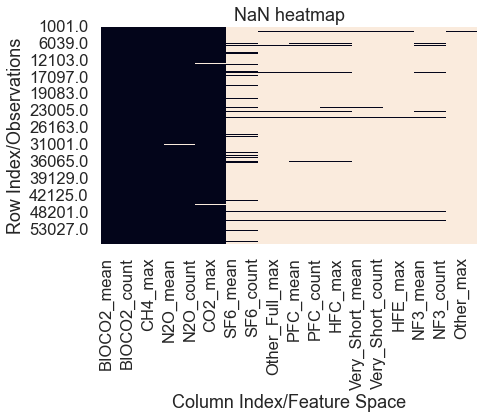

In [43]:
plot_nan_heatmap(fac)

To continue the cleaning, we will replace NaN columns by zeros. It makes sense as the companies not measuring specific types of gas emitted by the industry do this as they don't use those chemicals. For instance, a plant not using any product leading to PFC pollution doesn't need to track their emission related to this, as it would be 0.

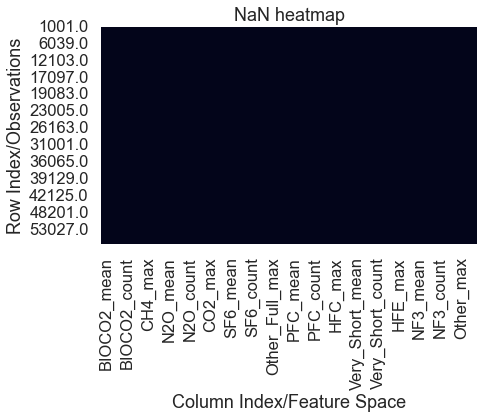

(746, 36)
Index(['BIOCO2_mean', 'BIOCO2_max', 'BIOCO2_count', 'CH4_mean', 'CH4_max',
       'CH4_count', 'N2O_mean', 'N2O_max', 'N2O_count', 'CO2_mean', 'CO2_max',
       'CO2_count', 'SF6_mean', 'SF6_max', 'SF6_count', 'Other_Full_mean',
       'Other_Full_max', 'Other_Full_count', 'PFC_mean', 'PFC_max',
       'PFC_count', 'HFC_mean', 'HFC_max', 'HFC_count', 'Very_Short_mean',
       'Very_Short_max', 'Very_Short_count', 'HFE_mean', 'HFE_max',
       'HFE_count', 'NF3_mean', 'NF3_max', 'NF3_count', 'Other_mean',
       'Other_max', 'Other_count'],
      dtype='object')
V_GHG_EMITTER_GAS.COUNTY_FIPS


In [51]:
fac = fac.fillna(0)
plot_nan_heatmap(fac)
print(fac.shape)
print(fac.columns)
print(fac.index.name)

# Data Extraction from pm25 and AQI level, county-wise

To compare the industry activity to PM2.5 levels, we use WHO's data on daily PM2.5 levels.

There is one issue though, as these data relates to 2016 data. We will try to match them. This can make sense, as industry and factory take a long amount of time to become operational and stay like this for a long time.



Tried to use: air_qual_df = pd.read_csv('./raw/data/us_air_quality_measures.csv')
-> shitty dataset


## Importing Data

,MeasureId,MeasureName,MeasureType,StratificationLevel,StateFips,StateName,CountyFips,CountyName,ReportYear,Value,Unit,UnitName,DataOrigin,MonitorOnly
0,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1027,Clay,1999,33.0,No Units,No Units,Monitor Only,1
1,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1051,Elmore,1999,5.0,No Units,No Units,Monitor Only,1
2,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1073,Jefferson,1999,39.0,No Units,No Units,Monitor Only,1
3,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1079,Lawrence,1999,28.0,No Units,No Units,Monitor Only,1
4,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1089,Madison,1999,31.0,No Units,No Units,Monitor Only,1


Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard (monitor and modeled data)                      34199
Number of person-days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard (monitor and modeled data)               34199
Percent of days with PM2.5 levels over the National Ambient Air Quality Standard (monitor and modeled data)                                                   34199
Number of person-days with PM2.5 over the National Ambient Air Quality Standard (monitor and modeled data)                                                    34199
Annual average ambient concentrations of PM 2.5 in micrograms per cubic meter, based on seasonal averages and daily measurement (monitor and modeled data)    34199
Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard                                                 10341
Number of person